<a href="https://colab.research.google.com/github/AminaTkh/AlanTuringInstitute_Bias_in_AI/blob/main/Mitigating-Bias-and-Discrimination/Inprocessing_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **In-processing technique: A Reductions Approach to Fairness for Statistical Parity**

The Reductions approach (Agarwal et al 2018) makes use of constrained optimisation to reduce binary classification to a series of cost-sensitive, weighted classification problems. The optimal solution is then an equilibrium between two min max expressions. The steps we will take are outlined below.

1. First, we will calculate fairness metrics for a base classifier
2. We will then apply the Reductions method to train a predictive model and observe the results.

# Install Libraries and load data

In [14]:
# install hai library
!pip install holisticai

import pickle
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeClassifier

from holisticai.bias.mitigation import ExponentiatedGradientReduction
from holisticai.bias import metrics as bias_metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Load the data into a dataframe

In [15]:
# suppress warnings
import warnings
warnings.simplefilter("ignore")

# Load data
from sklearn.datasets import fetch_openml
bunch = fetch_openml(data_id=44270)
df = bunch['frame'].dropna()
df['Ethnicity_White'] = (df['Ethnicity'] == 'White')*1
df = df.drop(columns = ['Gender', 'Ethnicity'])
df

,Label,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,Ethnicity_White
0,1,-0.178832,0.147077,0.775331,-0.427889,0.640818,-0.610427,-1.023371,1.431524,1.459619,...,-0.042387,-0.355889,-0.465837,-2.832634,0.917297,-0.241052,-2.122105,0.253170,0.164617,0
1,1,0.092276,0.122023,0.482935,-0.232131,-1.939064,-1.140216,-0.833250,-1.281904,0.228971,...,0.750136,-1.417751,1.254152,0.631731,1.665469,-0.388293,-0.804782,-0.227182,0.412375,0
2,0,-1.703377,-0.962149,-0.785495,-0.633902,-0.334718,-1.555958,0.825006,0.274443,1.448419,...,0.368800,0.079523,-0.932425,-0.693293,-0.114197,-1.252067,0.834270,-0.463270,0.559294,0
4,1,-0.363013,1.264307,1.667603,0.903941,-0.062840,0.680886,0.389930,-0.000803,-0.782676,...,0.784050,-0.311236,2.447118,1.127650,0.086733,-0.381553,0.209684,0.197809,-0.879914,0
5,0,0.152488,-0.731821,-0.167126,-1.193398,1.180502,0.469656,-0.044317,-0.409883,0.625990,...,-1.292245,-0.298833,2.067846,0.304233,-0.160228,1.017770,-1.002570,0.844326,-1.155311,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0,-1.706395,-0.435942,0.645464,-0.859816,0.914893,-0.022199,-0.424393,-0.976591,0.672857,...,-0.377802,0.181203,0.367494,0.162101,-1.688369,-1.151553,0.777658,-1.044357,-0.074341,0
9995,1,-0.057075,1.791513,-1.065756,-0.783341,-0.559215,1.042646,-1.154058,1.094753,1.968674,...,0.709753,0.021583,1.718576,1.171804,0.430075,3.340726,1.349216,1.481516,0.070563,0
9996,1,0.582066,0.086788,0.167259,-1.672798,1.537135,-1.113315,0.222907,-1.743083,-0.086986,...,0.150314,-0.072920,-1.841719,-0.807065,-0.793955,-1.098300,-1.474154,-0.828826,-0.891166,0
9997,0,-1.355098,-0.321228,-0.204290,0.498632,1.634130,0.847070,-0.552140,-1.614727,2.337347,...,0.688433,-1.781911,0.275032,0.690859,0.666878,0.644440,0.127891,1.277781,-0.744428,1


# Run a baseline predictive model without applying a fairness technique
First we will build a standard Ridge Classifier and observe some baseline results, using the original data and without a fairness technique.

Train a Ridge Classifier with 10 fold stratified cross validation. Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Equalized Odds Difference, False Negative Rate Difference, and Statistical Parity Difference)

This base code for the ridge regression classifier is provided for you. There are no gaps to fill in in this sections.

In [16]:
# Instantiate the classifier

model = RidgeClassifier()

# instantiate the cross-validation scheme
mv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# setup the performance metrics to be computed
perf_metrics = {"Accuracy": metrics.accuracy_score,
                "Precision": metrics.precision_score,
                "Recall": metrics.recall_score,
                "F1-Score": metrics.f1_score,
                }


In [17]:
# Train a baseline ridge regression classifier on the dataset before applying the Reductions method
k, i = True, 1

# instantiating X
X = df.drop(labels=['Label'], axis=1)

# instantiating the target variable
y = df['Label']

# 10 fold CV
for (train, test) in mv.split(X, y):

    # fit model
    X_train = X.iloc[train].copy()
    y_train = y.iloc[train].copy()
    model = model.fit(X_train, y_train)

    # get predictions in the test set

    ypred_class = model.predict(X.iloc[test])

    # compute performance metrics
    metric_list = []
    X_test = X.iloc[test].copy()
    y_test = y.iloc[test].copy()
    group_a = X_test.Ethnicity_White != 1
    group_b = X_test.Ethnicity_White == 1
    white = X_test['Ethnicity_White']
    for pf in perf_metrics.keys():
            metric_list += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]
    spd = bias_metrics.statistical_parity(group_a, group_b, ypred_class)
    eod = bias_metrics.average_odds_diff(group_a, group_b, ypred_class, y_test)
    fnrd = bias_metrics.false_negative_rate_diff(group_a, group_b, ypred_class, y_test)

    # Compute fairness metrics
    metric_list += [['Statistical Parity Difference', spd]]
    metric_list += [['Equalized Odds Difference', eod]]
    metric_list += [['False Negative Rate Difference', fnrd]]

    # concatenate results
    df_m = pd.DataFrame(metric_list, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics_orig = df_m.copy()
        k=0
    else:
        df_metrics_orig = pd.concat([df_metrics_orig, df_m.copy()], axis=0, ignore_index=True)

In [18]:
# Display metrics

metrics_table_orig = df_metrics_orig.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table_orig

,mean,std
,Value,Value
Metric,,
Accuracy,0.706002,0.008056
Equalized Odds Difference,-0.058629,0.017678
F1-Score,0.577810,0.011547
False Negative Rate Difference,0.090245,0.032354
Precision,0.630473,0.013622
Recall,0.533434,0.014296
Statistical Parity Difference,-0.062992,0.019121


# Use the Reductions approach to target Statistical Parity

Amend your Ridge Classifier routine above to apply the [Reductions](https://holisticai.readthedocs.io/en/latest/generated/holisticai.bias.mitigation.ExponentiatedGradientReduction.html#holisticai.bias.mitigation.ExponentiatedGradientReduction) approach when training the model. Compute performance metrics (Accuracy, Precision, Recall and F1 Score) and fairness metrics (Equalized Odds Difference, False Negative Rate Difference, Statistical Parity Difference)

In [19]:
# Train a ridge regression classifier on the dataset with inprocessing
model = RidgeClassifier()
k, i = True, 1

# instantiating X
X = df.drop(labels=['Label'], axis=1)

# instantiating the target variable
y = df['Label']

# 10 fold cv
for (train, test) in mv.split(X, y):

    # fit reductions in-processor
    X_train = X.iloc[train].copy()
    y_train = y.iloc[train].copy()
    group_a = X_train.Ethnicity_White != 1
    group_b = X_train.Ethnicity_White == 1

    # set up the in-processor
    gr = ExponentiatedGradientReduction()

    # incorporate model in gsr
    gr.transform_estimator(model)

    # fit with data
    gr.fit(X_train, y_train, group_a, group_b)

    # get predictions in the test set
    ypred_class = gr.predict(X.iloc[test])


    # compute performance metrics
    metric_list = []
    X_test = X.iloc[test].copy()
    y_test = y.iloc[test].copy()
    group_a = X_test.Ethnicity_White != 1
    group_b = X_test.Ethnicity_White == 1
    white = X_test['Ethnicity_White']
    for pf in perf_metrics.keys():
            metric_list += [[pf, perf_metrics[pf](y.iloc[test].values.ravel(), ypred_class)]]
    spd = bias_metrics.statistical_parity(group_a, group_b, ypred_class)
    eod = bias_metrics.average_odds_diff(group_a, group_b, ypred_class, y_test)
    fnrd = bias_metrics.false_negative_rate_diff(group_a, group_b, ypred_class, y_test)

    # Compute fairness metrics
    metric_list += [['Statistical Parity Difference', spd]]
    metric_list += [['Equalized Odds Difference', eod]]
    metric_list += [['False Negative Rate Difference', fnrd]]

    # concatenate results
    df_m = pd.DataFrame(metric_list, columns=["Metric", "Value"])
    df_m["Fold"] = i
    i += 1
    if k:
        df_metrics = df_m.copy()
        k=0
    else:
        df_metrics = pd.concat([df_metrics, df_m.copy()], axis=0, ignore_index=True)

In [21]:
# Display metrics

metrics_table_red = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table_red

,mean,std
,Value,Value
Metric,,
Accuracy,0.705091,0.005937
Equalized Odds Difference,-0.003876,0.016340
F1-Score,0.576968,0.004756
False Negative Rate Difference,0.022720,0.033056
Precision,0.628885,0.012894
Recall,0.533132,0.006646
Statistical Parity Difference,-0.010989,0.019159


# Present results to show the effectiveness of the Reductions method in Achieving Statistical Parity

Present graphs (bar charts work well) to show how each performance and fairness metric differs for the baseline model compared with the application of the reductions method. Show the target line for each metric on the graph.

In [22]:
# Present graphs


table = pd.concat([metrics_table_orig, metrics_table_red], axis=1).iloc[:,[0,2]]
table.columns = ['Baseline', 'Reduction']
table

,Baseline,Reduction
Metric,,
Accuracy,0.706002,0.705091
Equalized Odds Difference,-0.058629,-0.003876
F1-Score,0.577810,0.576968
False Negative Rate Difference,0.090245,0.022720
Precision,0.630473,0.628885
Recall,0.533434,0.533132
Statistical Parity Difference,-0.062992,-0.010989


In [24]:
table1 = table.drop(columns=['Reduction']).copy()
table1 = table1.rename(columns= {'Baseline':'Value'})
table1['Method'] = 'Original'
table2 = table.drop(columns=['Baseline']).copy()
table2 = table2.rename(columns= {'Reduction':'Value'})
table2['Method'] = 'Reduction'
table_res = pd.concat([table1, table2], axis = 0)

<Axes: xlabel='Metric', ylabel='Value'>

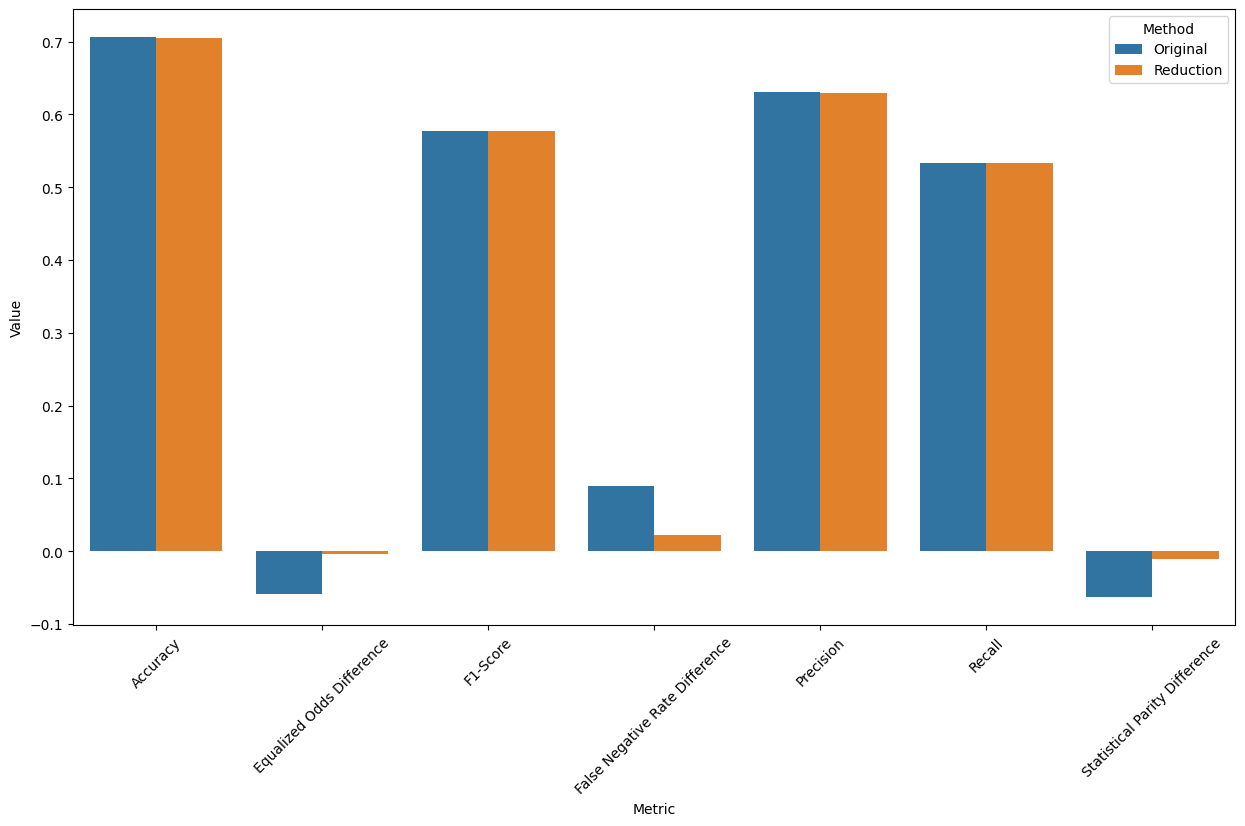

In [25]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.barplot(data=table_res, x=table_res.index, y="Value", hue='Method')